## Import Necessary Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import itertools
import random

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, \
GlobalAveragePooling2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras import models, layers 
from keras_preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import  Adam

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix

## Load the Files of Images

In [2]:
datagen = ImageDataGenerator()

In [3]:
train_path =  './data/fruits-360_dataset/fruits-360_2/Training'
test_path = './data/fruits-360_dataset/fruits-360_2/Test'
val_path = './data/fruits-360_dataset/fruits-360_2/Validation'

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range=10, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   channel_shift_range=10.)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
image_size = (100, 100)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = image_size,
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = image_size,
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical')

Found 2563 images belonging to 6 classes.
Found 954 images belonging to 6 classes.
Found 285 images belonging to 6 classes.


In [6]:
train_class_names = list(train_generator.class_indices.keys())
train_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [7]:
test_class_names = list(test_generator.class_indices.keys())
test_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [8]:
val_class_names = list(val_generator.class_indices.keys())
val_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

## Begin Modeling

#### Baseline Model

In [9]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [10]:
# enc_train_labels = to_categorical(train_labels) #/255
# enc_train_images = to_categorical(train_images)

# enc_test_labels = to_categorical(test_labels)/255
# enc_test_images = to_categorical(test_images)

# enc_val_labels = to_categorical(val_labels)/255
# enc_val_images = to_categorical(val_images)

In [11]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

In [12]:
# print(train_img.shape)
# print(test_img.shape)
# print(val_img.shape)

In [13]:
train_labels

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0.

In [14]:
train_images.shape

(32, 100, 100, 3)

In [15]:
train_labels.shape

(32, 6)

In [16]:
# train_y = np.reshape(train_labels[:,0], (32, ))
# test_y = np.reshape(test_labels[:,0], (32, ))
# val_y = np.reshape(val_labels[:,0], (32, ))

In [17]:
#Instantiate a Regularizer
reg = l2(3e-3)

In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
chosen_image = random.choice(os.listdir('./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/'))
image_path = './data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/' + chosen_image

In [20]:
image_path

'./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/r_128_100.jpg'

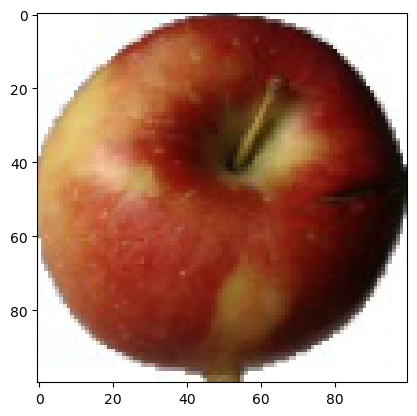

In [21]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [22]:
train_datagen.flow(image)

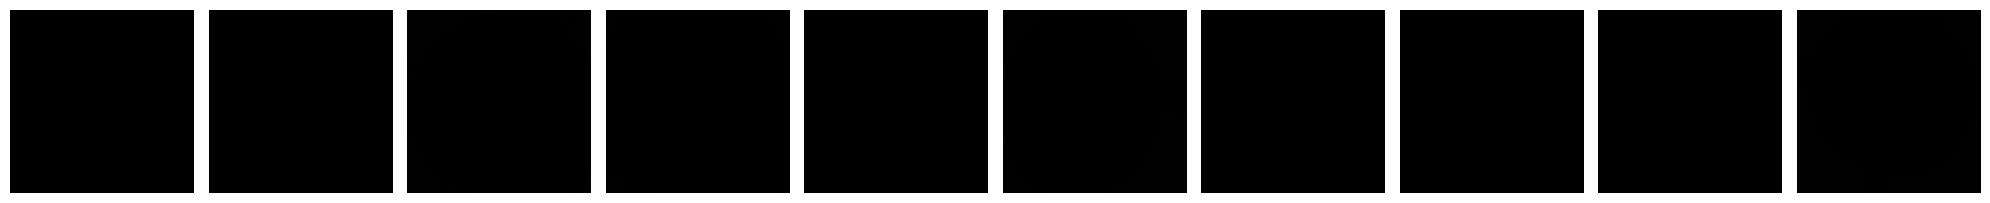

In [23]:
aug_iter = train_datagen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plotImages(aug_images)

In [24]:
len(os.listdir('./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn'))

438

In [25]:
names[0]

NameError: name 'names' is not defined

In [45]:
names = [os.path.join('./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/'
                      , name) for name in os.listdir('./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/')]

#loop through image names
for i in names:
    img = load_img(i)
    img = img_to_array(img)
    img = img.reshape((1,) + img.shape)
    train_datagen.flow(img,
                       save_to_dir='./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn', 
                       save_prefix='aug-image-', 
                       save_format='jpeg')
    
    

# img_path = names[91]
# img = load_img(img_path, target_size=(100, 100))

# reshape_img = img_to_array(img) 
# reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
# i=0
# for batch in train_datagen.flow(reshape_img, batch_size = 1):
#     plt.figure(i)
#     imgplot = plt.imshow(array_to_img(batch[0]))
#     i += 1
#     if i % 5 == 0:
#         break
# plt.show()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x16b0e23b0>

In [27]:
names[0]

'./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/107_100.jpg'

In [35]:
img_path

'./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/107_100.jpg'

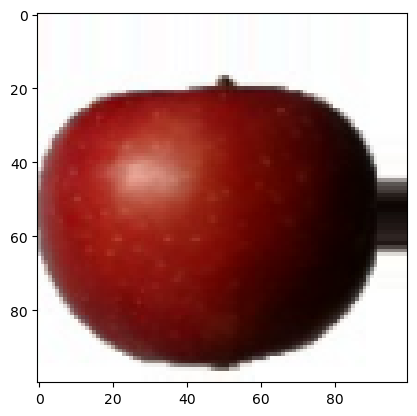

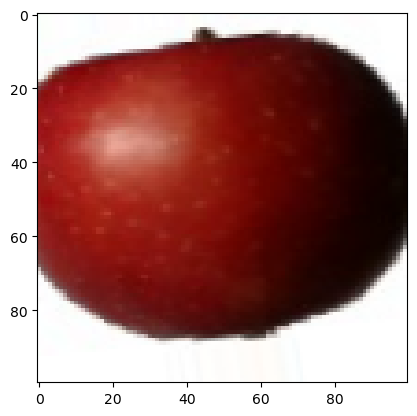

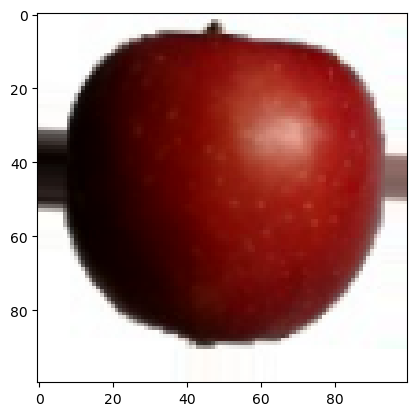

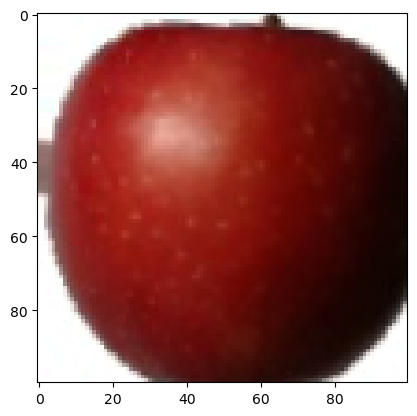

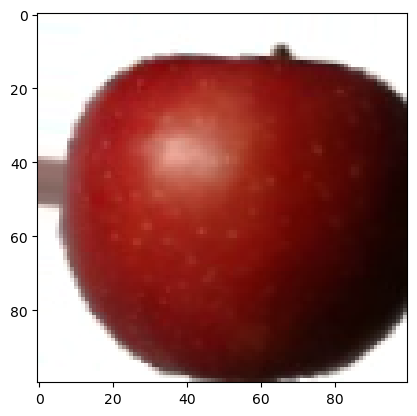

In [30]:
names = [os.path.join('./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/'
                      , name) for name in os.listdir('./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/')]

img_path = names[0]
img = load_img(img_path, target_size=(100, 100))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_datagen.flow(reshape_img, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break
plt.show()

In [31]:
for batch in train_datagen.flow(reshape_img, batch_size = 1):
    

SyntaxError: unexpected EOF while parsing (829773867.py, line 2)

In [32]:
# aug_iter = train_datagen.flow(augment_images, 
#                               save_to_dir='./data/fruits-360_dataset/fruits-360_2/Txraining/Apple Braeburn', 
#                               save_prefix='aug-image-', 
#                               save_format='jpeg')

In [98]:
# data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip("horizontal_and_vertical"),
#   layers.RandomRotation(0.2),
# ])

In [99]:
baseline_model = models.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                   layers.RandomRotation(0.2),])
baseline_model.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
baseline_model.add(layers.MaxPooling2D(2,2))
baseline_model.add(layers.Dropout(0.25))
baseline_model.add(layers.Conv2D(36, (3,3), activation='relu')) # 2 hidden layers
baseline_model.add(layers.MaxPooling2D(2,2))
#baseline_model.add(BatchNormalization())
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(36, activation='relu', kernel_regularizer = reg))
baseline_model.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
#baseline_model.add(layers.Dense(24, activation='relu', kernel_regularizer = reg))
baseline_model.add(layers.Dense(6, activation='softmax', kernel_regularizer = reg))
#Check example of dropout, towrards start, filyters
# CNNS Intro
# 

Metal device set to: Apple M1 Pro


2022-12-07 10:43:56.334667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 10:43:56.334958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [100]:
train_images.shape

(32, 100, 100, 3)

In [101]:
train_labels.shape

(32, 6)

In [102]:
opt = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', mode='min')


np.random.seed(42)
baseline_model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

baseline_histoire = baseline_model.fit(train_images,
                                       train_labels,
                                       #callbacks = [es],
                                       epochs = 50,
                                       batch_size = 32,
                                       validation_data = (val_images, val_labels))

Epoch 1/50


2022-12-07 10:43:58.401229: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 10:43:58.756766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 801ms/step - loss: 2.2043 - accuracy: 0.0625 - val_loss: 2.1929 - val_accuracy: 0.1875
Epoch 2/50
1/1 [==============================] - 0s 126ms/step - loss: 1.9894 - accuracy: 0.2500 - val_loss: 2.2685 - val_accuracy: 0.4688
Epoch 3/50


2022-12-07 10:43:59.156026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 118ms/step - loss: 2.0073 - accuracy: 0.2500 - val_loss: 2.2170 - val_accuracy: 0.2188
Epoch 4/50
1/1 [==============================] - 0s 127ms/step - loss: 1.9015 - accuracy: 0.4375 - val_loss: 2.0641 - val_accuracy: 0.2812
Epoch 5/50
1/1 [==============================] - 0s 112ms/step - loss: 1.8522 - accuracy: 0.3438 - val_loss: 1.9759 - val_accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 117ms/step - loss: 1.8284 - accuracy: 0.4375 - val_loss: 1.9437 - val_accuracy: 0.4375
Epoch 7/50
1/1 [==============================] - 0s 110ms/step - loss: 1.7213 - accuracy: 0.5000 - val_loss: 1.9279 - val_accuracy: 0.3438
Epoch 8/50
1/1 [==============================] - 0s 111ms/step - loss: 1.6179 - accuracy: 0.5312 - val_loss: 1.9086 - val_accuracy: 0.3438
Epoch 9/50
1/1 [==============================] - 0s 122ms/step - loss: 1.5038 - accuracy: 0.6562 - val_loss: 1.8737 - val_accuracy: 0.3438
Epoch 10/50
1/1 [==============

In [103]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (32, 100, 100, 3)         0         
                                                                 
 random_rotation (RandomRota  (32, 100, 100, 3)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (32, 98, 98, 18)          504       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 49, 49, 18)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 49, 49, 18)          0         
                                                                 
 conv2d_1 (Conv2D)           (32, 47, 47, 36)          5

In [104]:
baseline_results_train = baseline_model.evaluate(train_images, train_labels)
baseline_results_test = baseline_model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 23ms/step - loss: 1.1811 - accuracy: 0.6250


In [105]:
print(f'Baseline Train Results: {baseline_results_train}')
print(f'Baseline Test Results: {baseline_results_test}')

Baseline Train Results: [0.4580688178539276, 0.9375]
Baseline Test Results: [1.1810767650604248, 0.625]


#### Baseline Model Visualizations

#### Graphing Accuracy and Loss Metrics

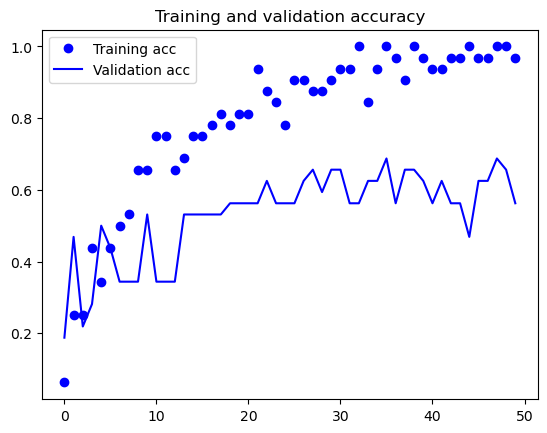

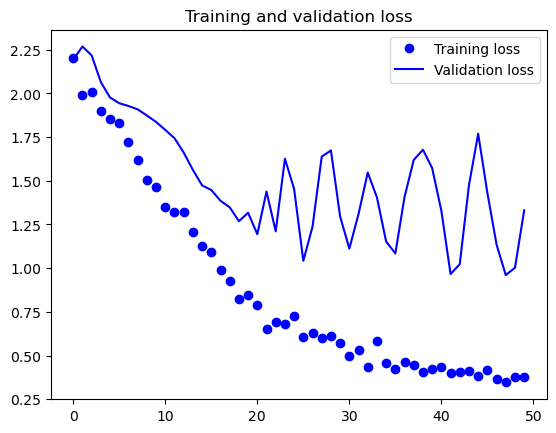

In [106]:
# Plot history
acc = baseline_histoire.history['accuracy']
val_acc = baseline_histoire.history['val_accuracy']
loss = baseline_histoire.history['loss']
val_loss = baseline_histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();



#### Confusion Matrix

In [107]:
test_images.shape

(32, 100, 100, 3)

In [108]:
baseline_predictions = baseline_model.predict(x = test_images, batch_size = 32, verbose = 0)
baseline_rounded_predictions = np.argmax(baseline_predictions, axis = -1)
baseline_rounded_labels = np.argmax(test_labels, axis=1)
baseline_cm = confusion_matrix(y_true = baseline_rounded_labels, y_pred = baseline_rounded_predictions)

2022-12-07 10:44:05.294359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
baseline_predictions

In [ ]:
baseline_rounded_labels

In [ ]:
baseline_rounded_labels

In [ ]:
baseline_rounded_predictions

In [ ]:
y_proba = baseline_model.predict(test_images)
predicted = np.argmax(y_proba, axis=-1)
predicted

In [ ]:
test_labels

In [ ]:
test_labels.shape

In [ ]:
# cm_digits = confusion_matrix(test_labels, predicted)
# disp = ConfusionMatrixDisplay(
#     confusion_matrix = cm_digits)

# disp.plot(cmap=plt.cm.Blues)
# plt.show()

In [ ]:
# argmax axis = -1 gets the column index of maximum probability for each row.
# column index corresponds to digit classes (numbers 0 -9)

# model_images = Sequential()

# y_proba = model_images.predict(x_test)
# y_proba

# predicted = np.argmax(y_proba, axis=-1)
# predicted

# cm_digits = confusion_matrix(y_test, predicted)
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm_digits)

# disp.plot(cmap=plt.cm.Blues)
# plt.show()

In [ ]:
def plot_confusion_matrix_func(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

In [ ]:
cm_plot_labels = test_class_names

In [ ]:
plot_confusion_matrix_func(cm = baseline_cm, classes = cm_plot_labels, title='Confusion Matrix')

In [ ]:
type(baseline_cm)

In [ ]:
test_labels

#### Second Model

In [ ]:
sz = 200

# Initializing the CNN
model1 = Sequential()

# First convolution layer and pooling
model1.add(Convolution2D(32, (3, 3), input_shape=(sz, sz, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))

# Second convolution layer and pooling
model1.add(Convolution2D(32, (3, 3), activation='relu'))
# input_shape is going to be the pooled feature maps from the previous convolution layer
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
model1.add(Flatten(input_shape = (28,28)))

# Adding a fully connected layer
model1.add(Dense(units=96, activation='relu'))
model1.add(Dropout(0.40))
model1.add(Dense(units=32, activation='relu'))
model1.add(Dense(units=24, activation='softmax')) # softmax for more than 2

In [ ]:
model1.summary()

In [ ]:
model1.compile(optimizer='adam',
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
               metrics=['accuracy'])

In [ ]:
# history = model1.fit(
#     train_generator,
#     validation_data = test_generator,
#     epochs = 5
# )